In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
from functools import partial

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow import keras

In [2]:
%load_ext watermark
%watermark -v -n -m -p numpy,sklearn,pandas,seaborn,tensorflow

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

numpy     : 1.23.5
sklearn   : 1.2.0
pandas    : 1.4.3
seaborn   : 0.12.2
tensorflow: 2.11.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit



## Identify a Deep Learning Problem

Neural Networks are the standard for image classification given their complexity. This project is an exploration of different types of NN's learned in the Introduction to Deep Learning course and their ability to classify simple images (fashion-MINST) compared to simpler machine learning algorithm such as KNN. 

The Fashion MINST dataset is collection of fashion article images, it consists of 70,000 examples in total and is a popular benchmarking dataset of machine learning algorithms as it is more complicated than the regular MINST dataset.

In [185]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [133]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

## Exploratory Data Analysis (EDA)

There are a total of 60,000 training and images and a total of 10,000 testing images.The dataframe train_labels contains the labels for the training images.

The images are 28x28 and are GrayScale images, giving us an input array of 96 by 96 by 1

In [134]:
print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [205]:
images_df = pd.DataFrame(np.array(class_names)[y_train], columns=['labels'])

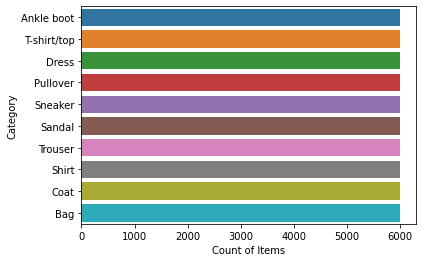

In [206]:
sns.barplot(data=images_df['labels'].value_counts().to_frame().reset_index(),
            x='labels',
            y='index')
plt.ylabel('Category')
plt.xlabel('Count of Items')
plt.show()

The data is known to be perfectly sampled.

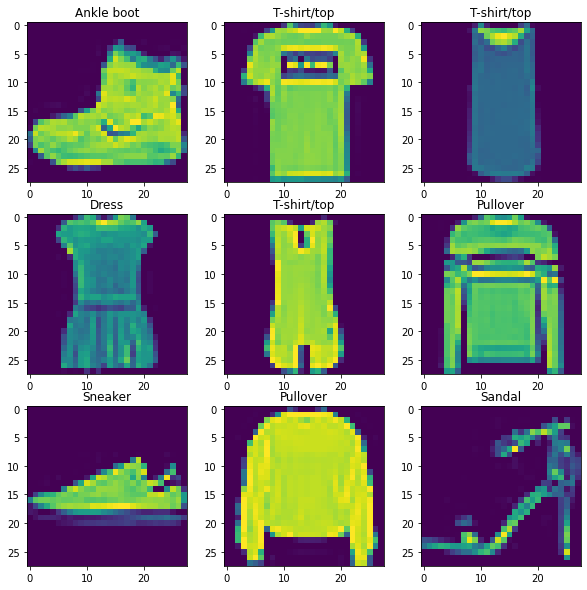

In [207]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
for image, prediction, axis in zip(X_train[:9], np.array(class_names)[y_train[:9]], axs):
    axis.imshow(image)
    axis.set_title(prediction)

Single the images are GrayScale, we can look at their sum and average of their intensity values and plot them to get an understanding of how they look like

In [228]:
images_df['TotalIntensity'] = X_train.reshape((60000, -1)).sum(axis=1)
images_df['MeanIntensity'] = np.mean(X_train.reshape((60000, -1)), axis=1)

[Text(0.5, 1.0, 'Box Plot for Average Intensity')]

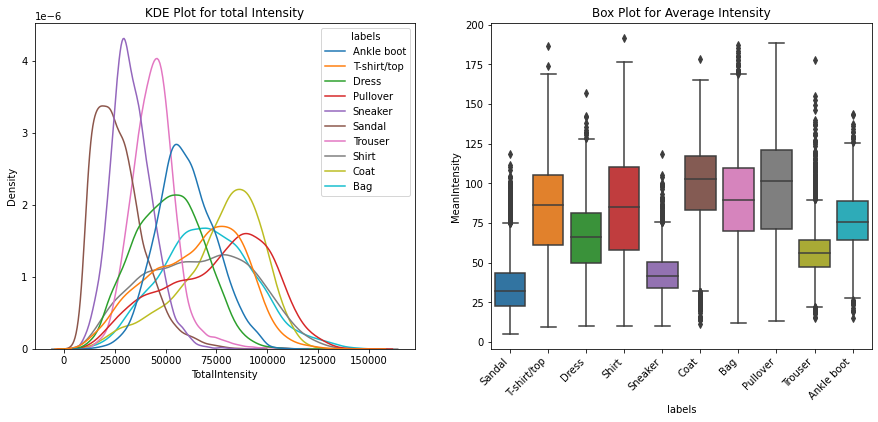

In [239]:
figs, axs = plt.subplots(ncols=2,
                        figsize=(15,6))

g1 = sns.kdeplot(data=images_df,
            x='TotalIntensity',
            hue='labels',
            ax=axs[0]).set(title='KDE Plot for total Intensity')

g2 = sns.boxplot(data=images_df,
                y=images_df['MeanIntensity'],
                x='labels',
                ax=axs[1])

g2.set_xticklabels(g2.get_xticklabels(), rotation=45, ha='right')
g2.set(title='Box Plot for Average Intensity')

## Analysis Using Models

We will analyze three models, a KNN, a MLP and a CNN 

### k Nearest Neighbors

We need to reshape the input data for the KNN model (images are 3D, need 2D data)

In [240]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train.reshape((60000, -1)), y_train)

KNeighborsClassifier(n_neighbors=3)

In [241]:
knn_predictions = knn.predict(X_test.reshape((10000, -1)))

In [242]:
knn_predictions

array([9, 2, 1, ..., 8, 1, 7], dtype=uint8)

#### Results

In [243]:
print("Accuracy ->", accuracy_score(knn_predictions, y_test))
print(classification_report(mlp_predicted_classes, y_test))

Accuracy -> 0.8541
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1011
           1       0.96      0.99      0.98       967
           2       0.90      0.62      0.73      1451
           3       0.89      0.87      0.88      1017
           4       0.64      0.85      0.73       749
           5       0.95      0.98      0.97       973
           6       0.58      0.71      0.64       826
           7       0.96      0.93      0.95      1038
           8       0.96      0.98      0.97       973
           9       0.95      0.96      0.95       995

    accuracy                           0.86     10000
   macro avg       0.86      0.87      0.86     10000
weighted avg       0.87      0.86      0.86     10000



[Text(0, 0, 'T-shirt/top'),
 Text(1, 0, 'Trouser'),
 Text(2, 0, 'Pullover'),
 Text(3, 0, 'Dress'),
 Text(4, 0, 'Coat'),
 Text(5, 0, 'Sandal'),
 Text(6, 0, 'Shirt'),
 Text(7, 0, 'Sneaker'),
 Text(8, 0, 'Bag'),
 Text(9, 0, 'Ankle boot')]

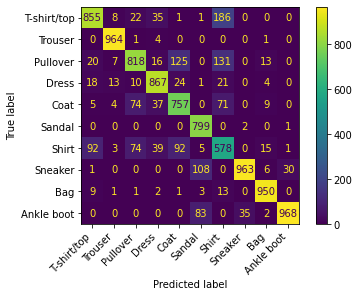

In [198]:
cf_matrix = ConfusionMatrixDisplay(confusion_matrix(knn_predictions, 
                                                    y_test,
                                                    labels=np.arange(0,10)),
                                                   display_labels=class_names)
cf_matrix.plot()
cf_matrix.ax_.set_xticklabels(cf_matrix.ax_.get_xticklabels(), rotation=45, ha='right')

The KNN model had a resulting accuracy of 0.8541, quite impressive. 

### Multilayer Perceptrons

In [151]:
# Get a validation dataset from the training dataset 
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train
                                                     ,test_size=.2)

In [179]:
# Using a simple MLP
mlp_model = keras.models.Sequential([
                            keras.layers.Flatten(input_shape=[28, 28]),
                            keras.layers.Dense(400, activation="relu"),
                            keras.layers.Dense(200, activation="relu"),
                            keras.layers.Dropout(0.2),
                            keras.layers.Dense(100, activation="relu"),
                            keras.layers.Dropout(0.2),    
                            keras.layers.Dense(10, activation="softmax")
                        ])

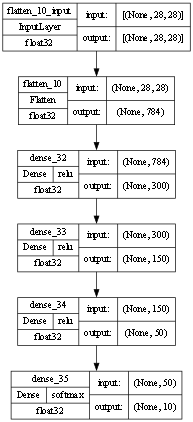

In [247]:
# Get a visual view of the architecture
keras.utils.plot_model(mlp_model, show_shapes=True, show_dtype=True, 
                       show_layer_names=True, expand_nested=True,
                        dpi=50, show_layer_activations=True,
)

In [181]:
mlp_model.compile(loss="sparse_categorical_crossentropy", # Loss function
                optimizer="adam", # Gradient Descent
                metrics=["accuracy"])
mlp_history = mlp_model.fit(X_train, y_train,
                            epochs=50,
                            validation_data=(X_valid, y_valid),
                            batch_size = 10)

Epoch 1/50
4800/4800 [==============================] - 13s 3ms/step - loss: 1.7572 - accuracy: 0.5403 - val_loss: 1.1754 - val_accuracy: 0.5163
Epoch 2/50
4800/4800 [==============================] - 13s 3ms/step - loss: 1.0797 - accuracy: 0.5426 - val_loss: 1.0644 - val_accuracy: 0.5249
Epoch 3/50
4800/4800 [==============================] - 12s 2ms/step - loss: 0.8380 - accuracy: 0.6609 - val_loss: 0.7041 - val_accuracy: 0.7230
Epoch 4/50
4800/4800 [==============================] - 12s 2ms/step - loss: 0.6399 - accuracy: 0.7433 - val_loss: 0.6079 - val_accuracy: 0.7386
Epoch 5/50
4800/4800 [==============================] - 13s 3ms/step - loss: 0.5993 - accuracy: 0.7555 - val_loss: 0.6046 - val_accuracy: 0.7565
Epoch 6/50
4800/4800 [==============================] - 13s 3ms/step - loss: 0.5562 - accuracy: 0.7819 - val_loss: 0.6626 - val_accuracy: 0.7825
Epoch 7/50
4800/4800 [==============================] - 13s 3ms/step - loss: 0.5065 - accuracy: 0.8254 - val_loss: 0.4816 - val_ac

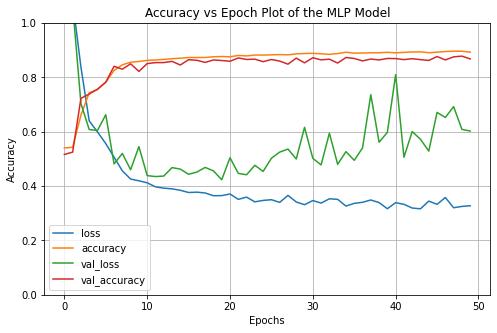

In [182]:
pd.DataFrame(mlp_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_ylim(0, 1)
plt.title('Accuracy vs Epoch Plot of the MLP Model')
plt.show()

In [183]:
mlp_predicted_classes = np.argmax(mlp_model.predict(X_test), axis=1)

313/313 [==============================] - 1s 2ms/step


#### Results

In [184]:
print("Accuracy ->", accuracy_score(mlp_predicted_classes, y_test))
print(classification_report(mlp_predicted_classes, y_test))

Accuracy -> 0.8612
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1011
           1       0.96      0.99      0.98       967
           2       0.90      0.62      0.73      1451
           3       0.89      0.87      0.88      1017
           4       0.64      0.85      0.73       749
           5       0.95      0.98      0.97       973
           6       0.58      0.71      0.64       826
           7       0.96      0.93      0.95      1038
           8       0.96      0.98      0.97       973
           9       0.95      0.96      0.95       995

    accuracy                           0.86     10000
   macro avg       0.86      0.87      0.86     10000
weighted avg       0.87      0.86      0.86     10000



[Text(0, 0, 'T-shirt/top'),
 Text(1, 0, 'Trouser'),
 Text(2, 0, 'Pullover'),
 Text(3, 0, 'Dress'),
 Text(4, 0, 'Coat'),
 Text(5, 0, 'Sandal'),
 Text(6, 0, 'Shirt'),
 Text(7, 0, 'Sneaker'),
 Text(8, 0, 'Bag'),
 Text(9, 0, 'Ankle boot')]

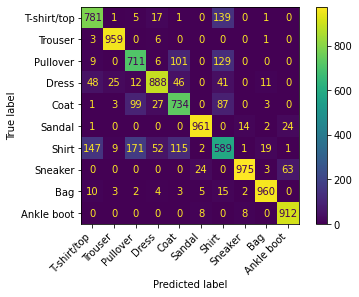

In [178]:
cf_matrix = ConfusionMatrixDisplay(confusion_matrix(mlp_predicted_classes, 
                                                    y_test,
                                                    labels=np.arange(0,10)),
                                                   display_labels=class_names)
cf_matrix.plot()
cf_matrix.ax_.set_xticklabels(cf_matrix.ax_.get_xticklabels(), rotation=45, ha='right')

The MLP model trained for just over three minute. The initial results with just two layers was 0.851. After adding another layer along with dropout layers it improved to 0.862 but the training time increased to over 12 minutes. 
Its resulting accuracy is slightly higher than the KNN model but not significantly. 

Based on the confusion matrix we can see that the model struggles to identify Shirts, frequently misclassifying them as T-shirts/tops, Pullovers and Coats. The reverse is also a pattern where these are classified as shirts.

### Convolutional Neural Network

In [119]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

In [120]:
cnn_model = keras.models.Sequential([
                    DefaultConv2D(filters=64, kernel_size=6, input_shape=[28, 28, 1]),
                    keras.layers.MaxPooling2D(pool_size=2), # Pool
                    DefaultConv2D(filters=128),
                    DefaultConv2D(filters=128),
                    keras.layers.MaxPooling2D(pool_size=2), # Pool
                    DefaultConv2D(filters=256),
                    DefaultConv2D(filters=256),
                    keras.layers.MaxPooling2D(pool_size=2), # Pool
                    keras.layers.Flatten(),
                    keras.layers.Dense(units=128, activation='relu'),
                    keras.layers.Dropout(0.2),
                    keras.layers.Dense(units=64, activation='relu'),
                    keras.layers.Dropout(0.2),
                    keras.layers.Dense(units=10, activation='softmax'),
                ])

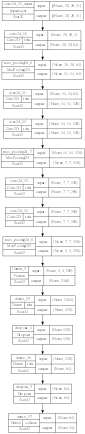

In [248]:
# Get a visual view of the architecture
keras.utils.plot_model(cnn_model, show_shapes=True, show_dtype=True, 
                       show_layer_names=True, expand_nested=True,
                        dpi=20, show_layer_activations=True,
)

In [123]:
cnn_model.compile(loss="sparse_categorical_crossentropy", # Loss function
                optimizer="adam", # Gradient Descent
                metrics=["accuracy"])
cnn_model_history = cnn_model.fit(X_train, y_train,
                        epochs=20,
                        validation_data=(X_valid, y_valid))

Epoch 1/20
1500/1500 [==============================] - 210s 139ms/step - loss: 0.5960 - accuracy: 0.7924 - val_loss: 0.3620 - val_accuracy: 0.8620
Epoch 2/20
1500/1500 [==============================] - 245s 163ms/step - loss: 0.3777 - accuracy: 0.8656 - val_loss: 0.3395 - val_accuracy: 0.8697
Epoch 3/20
1500/1500 [==============================] - 284s 189ms/step - loss: 0.3362 - accuracy: 0.8784 - val_loss: 0.3184 - val_accuracy: 0.8843
Epoch 4/20
1500/1500 [==============================] - 275s 183ms/step - loss: 0.3105 - accuracy: 0.8868 - val_loss: 0.3019 - val_accuracy: 0.8897
Epoch 5/20
1500/1500 [==============================] - 269s 179ms/step - loss: 0.2943 - accuracy: 0.8948 - val_loss: 0.2984 - val_accuracy: 0.8921
Epoch 6/20
1500/1500 [==============================] - 266s 177ms/step - loss: 0.2856 - accuracy: 0.8975 - val_loss: 0.2655 - val_accuracy: 0.9028
Epoch 7/20
1500/1500 [==============================] - 258s 172ms/step - loss: 0.2754 - accuracy: 0.9010 - val_

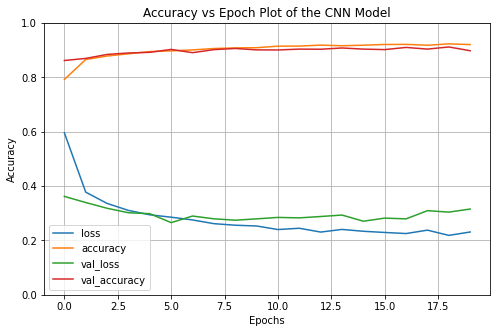

In [125]:
pd.DataFrame(cnn_model_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_ylim(0, 1)
plt.title('Accuracy vs Epoch Plot of the CNN Model')
plt.show()

In [126]:
cnn_model_classes = np.argmax(cnn_model.predict(X_test), axis=1)

313/313 [==============================] - 24s 75ms/step


#### Results

In [127]:
print("Accuracy ->", accuracy_score(cnn_model_classes, y_test))
print(classification_report(cnn_model_classes, y_test))

Accuracy -> 0.8932
              precision    recall  f1-score   support

           0       0.92      0.76      0.83      1205
           1       0.98      1.00      0.99       982
           2       0.91      0.76      0.83      1198
           3       0.90      0.91      0.90       985
           4       0.79      0.84      0.82       935
           5       0.98      0.97      0.98      1019
           6       0.56      0.81      0.66       693
           7       0.96      0.96      0.96      1005
           8       0.98      0.98      0.98       997
           9       0.96      0.98      0.97       981

    accuracy                           0.89     10000
   macro avg       0.89      0.90      0.89     10000
weighted avg       0.90      0.89      0.90     10000



[Text(0, 0, 'T-shirt/top'),
 Text(1, 0, 'Trouser'),
 Text(2, 0, 'Pullover'),
 Text(3, 0, 'Dress'),
 Text(4, 0, 'Coat'),
 Text(5, 0, 'Sandal'),
 Text(6, 0, 'Shirt'),
 Text(7, 0, 'Sneaker'),
 Text(8, 0, 'Bag'),
 Text(9, 0, 'Ankle boot')]

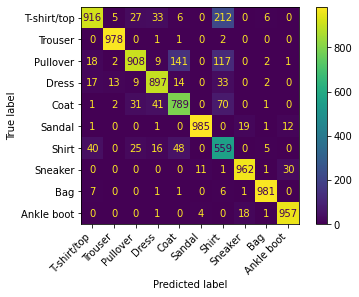

In [128]:
cf_matrix = ConfusionMatrixDisplay(confusion_matrix(cnn_model_classes, 
                                                    y_test,
                                                    labels=np.arange(0,10)),
                                                   display_labels=class_names)
cf_matrix.plot()
cf_matrix.ax_.set_xticklabels(cf_matrix.ax_.get_xticklabels(), rotation=45, ha='right')

## Results and Conclusion

The CNN model performs a lot better, with an accuracy of  0.893. It took a lot longer to train (around 40 minutes) but the inference time wasn't significantly longer and the accuracy, precision and recall scores are a lot better.

Based on the confusion matrix we can see that the model continues to struggles for Shirts, T-shirts/tops, Pullovers and Coats. This is somewhat easy to understand because of the similarity between these products. The KDE plot during the EDA has similar, larger intensity values for these categories that occupy a similar range of intensity and overall shape.

If the images were actually in the RGB scale, we know the KNN model would not be able to preform as well while the convolution model would have a better score. Future projects based off of this could be to replicate similar findings for a different dataset or focus on a better classifier using CNNs.

## References

<br>Fashion MINST https://github.com/zalandoresearch/fashion-mnist</br>
<br>ML Book https://github.com/rasbt/machine-learning-book</br>